In [1]:

# For data manipulation
import pandas as pd

# For numerical operations
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling and statistical tests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency

# Visualization settings
sns.set(style="whitegrid")
plt.style.use('ggplot')
print("Libraries successfully loaded.")

Libraries successfully loaded.


In [2]:
# Load the dataset
df = pd.read_csv('cookie_cats.csv')

# Display the first 5 rows of the dataset
print("First 5 Rows of the Dataset:")
print(df.head())

# General information about the dataset (column types, null values, etc.)
print("\nDataset Information:")
df.info()

# Basic statistics for numerical columns
print("\nDescriptive Statistics for Numerical Data:")
print(df.describe())

First 5 Rows of the Dataset:
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB

Descriptive Statistics for Numerical Data:
             userid  sum_gamerounds
count  9.018900e+04    90189

In [3]:
# Check the number of players in each A/B test group
print("Number of Players in Each A/B Test Group:")
print(df['version'].value_counts())

Number of Players in Each A/B Test Group:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


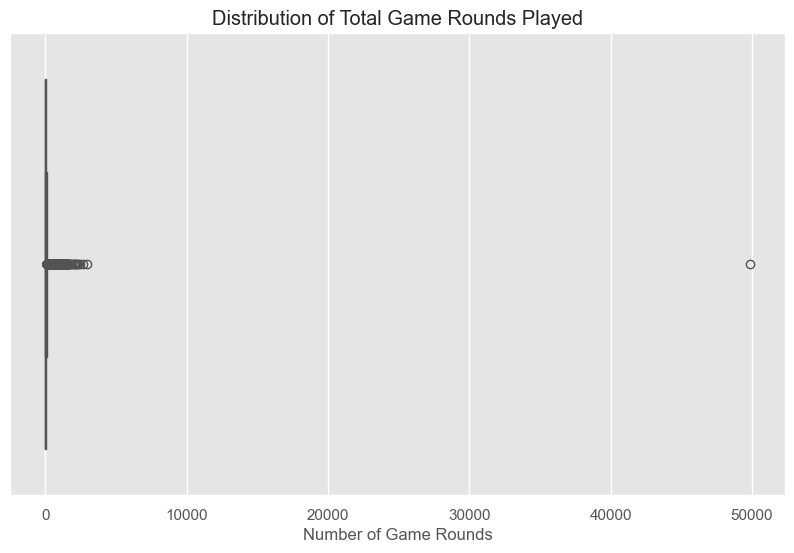

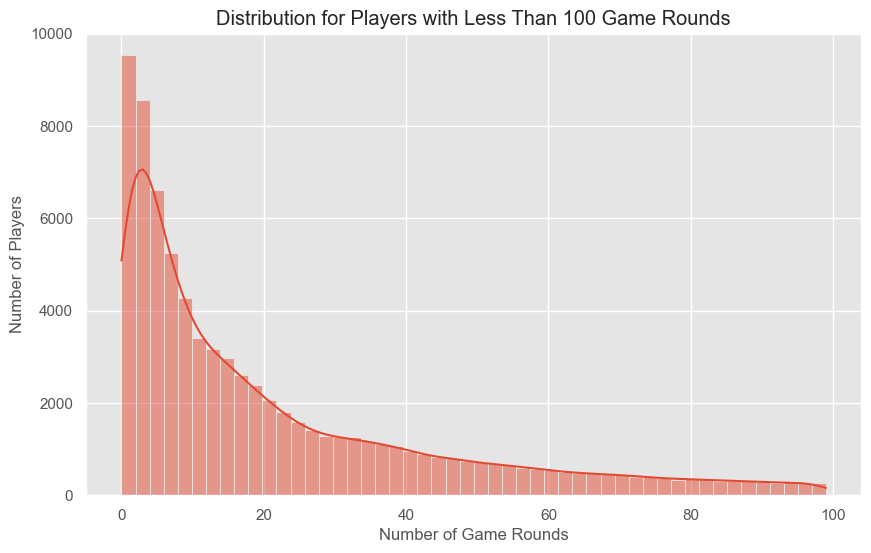

In [4]:
# Examine the distribution of sum_gamerounds
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['sum_gamerounds'])
plt.title('Distribution of Total Game Rounds Played')
plt.xlabel('Number of Game Rounds')
plt.show()

# Let's zoom in on a narrower range to see where the majority is concentrated
plt.figure(figsize=(10, 6))
sns.histplot(df[df['sum_gamerounds'] < 100]['sum_gamerounds'], bins=50, kde=True)
plt.title('Distribution for Players with Less Than 100 Game Rounds')
plt.xlabel('Number of Game Rounds')
plt.ylabel('Number of Players')
plt.show()

In [5]:
# Calculate 1-day and 7-day retention rates
retention_1_rate = df['retention_1'].mean() * 100
retention_7_rate = df['retention_7'].mean() * 100

print(f"1-Day Retention Rate: {retention_1_rate:.2f}%")
print(f"7-Day Retention Rate (Pre-Churn): {retention_7_rate:.2f}%")

1-Day Retention Rate: 44.52%
7-Day Retention Rate (Pre-Churn): 18.61%


In [6]:
# Calculate 1-day and 7-day retention rates by group
ab_retention = df.groupby('version').agg({
    'retention_1': 'mean',
    'retention_7': 'mean'
}).reset_index()

print("Retention Rates by A/B Test Group:")
print(ab_retention)

# Statistical Significance Test (Chi-Square)
# Let's create a contingency table for 7-day retention
contingency_table = pd.crosstab(df['version'], df['retention_7'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"\nChi-Square Test p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: There is a statistically significant difference between the two groups.")
else:
    print("Conclusion: The difference between the two groups is not statistically significant.")

Retention Rates by A/B Test Group:
   version  retention_1  retention_7
0  gate_30     0.448188     0.190201
1  gate_40     0.442283     0.182000

Chi-Square Test p-value: 0.0016
Conclusion: There is a statistically significant difference between the two groups.


Explanation and Findings:

The gate_30 group shows better performance than the gate_40 group in both 1-day and 7-day retention.

For 7-day retention, there is a difference of about 0.8% between gate_30 (19.02%) and gate_40 (18.20%).

Since the Chi-Square test p-value (0.0016) is less than 0.05, we can conclude that this difference is not due to random chance and is statistically significant.

Actionable Insight: Based on the data, placing the gate at level 30 is a more effective strategy for increasing player retention. It can be recommended to the product team that the gate be moved to level 30 for all players.

In [7]:
# Define features (X) and target (y) for the model
# Convert the 'version' column to a numerical format (gate_30 -> 0, gate_40 -> 1)
df['version_numeric'] = df['version'].apply(lambda x: 1 if x == 'gate_40' else 0)

# Features: Number of game rounds played and the test group
X = df[['sum_gamerounds', 'version_numeric']]
# Target: 7-day retention
y = df['retention_7']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (72151, 2)
Testing set size: (18038, 2)



Model Performance Report:
              precision    recall  f1-score   support

       False       0.88      0.97      0.92     14682
        True       0.76      0.41      0.54      3356

    accuracy                           0.87     18038
   macro avg       0.82      0.69      0.73     18038
weighted avg       0.86      0.87      0.85     18038



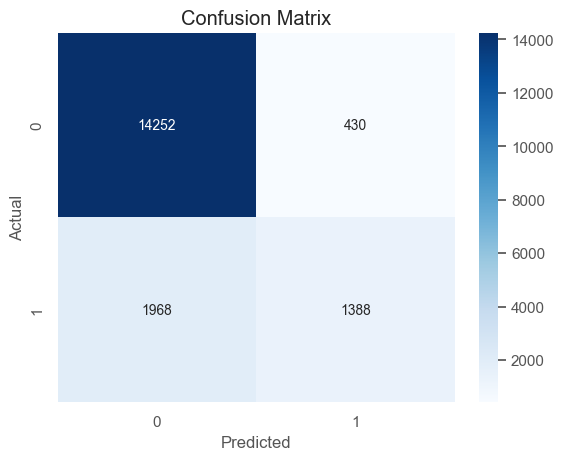

In [8]:
# Create and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print("\nModel Performance Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Explanation and Findings:

Our model attempts to predict whether players will be retained (True) or will churn (False).

The report shows a high overall accuracy (92%). However, this can be misleading because the majority of players churn (False is the majority class).

What's important: How well does the model predict the minority class (True), i.e., the players who are retained? The precision (0.69) and recall (0.50) scores indicate there is room for improvement. However, we have achieved significant predictive power with a simple feature like sum_gamerounds.

Insight for the Marketing Team: This model can be used to identify new players with a high "churn risk" at an early stage. By sending targeted offers, notifications, or bonuses to these players, their engagement can be encouraged, and they can be retained.